#FGSM : 
* 구글 드라이브 preprocessed 완전 비우고 다시 코드 돌려서 저장하고 class 확인까지 해야할 것 같음 (중복되는 내용, 다른 dir로 섞여 들어간 거 혼합상태인듯)
* preprocessed 코드 수정 하고 이미지 만들면, 그거를 mount해서 사용하는 걸로 코드 수정해야할 것 같음 : 시간 너무 오래 걸림


## 해야할 것
* 동일한 사진의 원본과 adversarial 샘플 육안으로 비교하는 과정 필요 : 외형 차이 없음을 보여야 함. 육안으로 품질 비교
* 원래 기울기 값을 그대로 쓰는 것 VS FGSM 성능 비교
* CNN 적용한 adversarial example (CNN 역전파 있음, flatten 부분에 처리해서 하면?)
* CNN + RGB 적용한 adversarial example (R/G/B plane 각각 따로?)
* R, G, B 각각 gradient 계산해서 합치기?

FGSM TF 구현
- gradient tape 모든 레이어에 적용되는지
- CNN의 gradient 가져온 건지 확인하기

# 1. Data Mount & Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras
import os
from PIL import Image
import natsort
import io
import cv2

In [ ]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


# 2. Data Load & Preprocessing

In [ ]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [ ]:
traininfo

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [ ]:
# 43개 클래스 모두 사용
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
imgs_path = "Train"
data_list = []
labels_list = []
result_class = [14,17,27]
for i in result_class:
    i_path = os.path.join(imgs_path, str(i)) #14, 17, 27
    for img in os.listdir(i_path):
        im = Image.open(i_path +'/'+ img)
        im = im.resize((32,32))
        im = np.array(im)
        data_list.append(im)
        labels_list.append(i)
data = np.array(data_list)
labels = np.array(labels_list)
print("Done")

Done


In [ ]:
import natsort

imgs_path = "Test"
data_list = []
labels_list = []

for img in natsort.natsorted(os.listdir(imgs_path)):
    im = Image.open(imgs_path +'/'+ img)
    im = im.resize((32,32))
    im = np.array(im)
    data_list.append(im)
data_test = np.array(data_list)

for i in range(len(testinfo.ClassId)):
    labels_list.append(testinfo.ClassId[i])

labels_test = np.array(labels_list)
print("Done")

Done


In [ ]:
labels_test

array([16,  1, 38, ...,  6,  7, 10])

In [ ]:
labels_test_index = []
for i in range(len(labels_test)):
    if (labels_test[i] == 14) | (labels_test[i] == 17) | (labels_test[i] == 27):
        labels_test_index.append(i)

In [ ]:
len(labels_test_index)

690

In [ ]:
data_test.shape

(12630, 32, 32, 3)

In [ ]:
test_data = []
test_label = []
for i in labels_test_index:
    test_data.append(data_test[i])
    test_label.append(labels_test[i])
data_test = np.array(test_data)   
labels_test = np.array(test_label)

In [ ]:
data_test.shape

(690, 32, 32, 3)

In [ ]:
labels_test.shape

(690,)

14


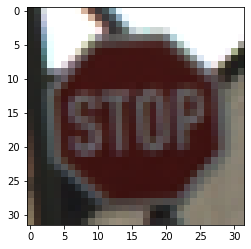

In [ ]:
print(labels_test[300])
plt.imshow(data_test[300])
plt.show()

17


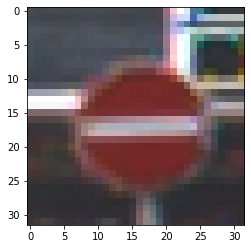

In [ ]:
print(labels[1000])
plt.imshow(data[1000])
plt.show()

In [ ]:
data_R = data[:,:,:,0]
data_G = data[:,:,:,1]
data_B = data[:,:,:,2]

data_test_R = data_test[:,:,:,0]
data_test_G = data_test[:,:,:,1]
data_test_B = data_test[:,:,:,2]

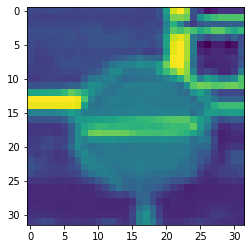

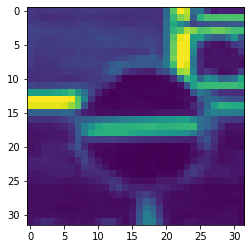

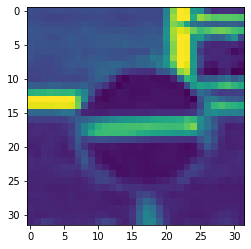

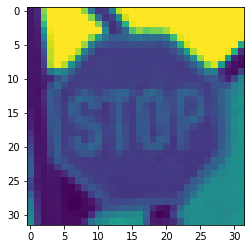

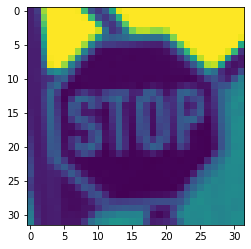

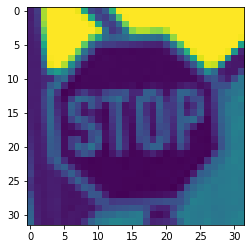

In [ ]:
plt.imshow(data_R[1000])
plt.show()
plt.imshow(data_G[1000])
plt.show()
plt.imshow(data_B[1000])
plt.show()

plt.imshow(data_test_R[300])
plt.show()
plt.imshow(data_test_G[300])
plt.show()
plt.imshow(data_test_B[300])
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

class ANN:
    def __init__(self, layers_size):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = []
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def initialize_parameters(self):
        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(self.layers_size[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_size[l], 1))
    
    def forward(self, X):
        store = {}
 
        A = X.T
        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A) + self.parameters["b" + str(l + 1)]
            A = self.sigmoid(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
 
        Z = self.parameters["W" + str(self.L)].dot(A) + self.parameters["b" + str(self.L)]
        A = self.softmax(Z)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z
 
        return A, store
 
    def sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return s * (1 - s)

    def backward(self,X,Y,store):

        derivatives = {}

        store['A0'] = X.T

        A = store['A' + str(self.L)]
        dZ = A - Y.T

        dW = dZ.dot(store['A' + str(self.L - 1)].T) / self.n
        db = np.sum(dZ, axis = 1, keepdims = True) / self.n
        dAPrev = store['W' + str(self.L)].T.dot(dZ)

        derivatives['dW' + str(self.L)] = dW
        derivatives['db' + str(self.L)] = db

        for l in range(self.L - 1,0,-1):
            dZ = dAPrev * self.sigmoid_derivative(store['Z' + str(l)])
            dW = dZ.dot(store['A' + str(l-1)].T) / self.n
            db = np.sum(dZ, axis = 1, keepdims = True) / self.n
            if l > 1:
                dAPrev = store['W' + str(l)].T.dot(dZ)
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db

        return derivatives
    
    def backward_ad(self,X,Y,store):

        derivatives = {}

        store['A0'] = X.T

        A = store['A' + str(self.L)]
        dZ = A - Y.T

        dW = dZ.dot(store['A' + str(self.L - 1)].T) / self.n
        db = np.sum(dZ, axis = 1, keepdims = True) / self.n
        dAPrev = store['W' + str(self.L)].T.dot(dZ)

        derivatives['dW' + str(self.L)] = dW
        derivatives['db' + str(self.L)] = db

        for l in range(self.L - 1,0,-1):
            dZ = dAPrev * self.sigmoid_derivative(store['Z' + str(l)])
            dW = dZ.dot(store['A' + str(l-1)].T) / self.n
            db = np.sum(dZ, axis = 1, keepdims = True) / self.n
            if l > 1:
                dAPrev = store['W' + str(l)].T.dot(dZ)
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
            dAPrev_0 = store['W' + str(l)].T.dot(dZ)

        return dAPrev_0

    def fit(self, X, Y, learning_rate=0.01, n_iterations=300):
        self.n = X.shape[0]
 
        self.layers_size.insert(0, X.shape[1])
 
        self.initialize_parameters()
        for loop in range(n_iterations):
            A, store = self.forward(X)
            cost = -np.mean(Y * np.log(A.T+ 1e-8))
            derivatives = self.backward(X, Y, store)
 
            for l in range(1, self.L + 1):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives["dW" + str(l)]
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - learning_rate * derivatives["db" + str(l)]
 
            if loop % 100 == 0:
                print("Cost: ", cost, "Train Accuracy:", self.predict(X, Y))
 
            if loop % 10 == 0:
                self.costs.append(cost)

    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
    
    def predict_output(self, X):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        return y_hat

    def predict_rgb_proba(self,X):
        A, _ = self.forward(X)

        return A

    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()

def pre_process_data(train_x, train_y):
    # Normalize
    train_x = train_x / 255.
 
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
    
    train_x_flatten = train_x.reshape(train_x.shape[0],-1)
    
    return train_x_flatten, train_y

In [ ]:
def rgb_predict(X_R, X_G, X_B, Y):
    A = X_R + X_G + X_B
    y_hat = np.argmax(A, axis=0)
    Y = np.argmax(Y, axis=1)
    accuracy = (y_hat == Y).mean()
    return accuracy * 100

In [ ]:
if __name__ == '__main__':
    (train_x_R, train_y_R) = data_R , labels


    train_x_R, train_y_R = pre_process_data(train_x_R, train_y_R)

    print("train_x_R's shape: " + str(train_x_R.shape))
    print("train_y_R's shape: " + str(train_y_R.shape))
     
    layers_dims = [50, 3]
 
    ann_R = ANN(layers_dims)

    ann_R.fit(train_x_R, train_y_R, learning_rate=0.1, n_iterations=1000)

    prediction_R = ann_R.predict_rgb_proba(train_x_R)

    print(prediction_R.shape)

train_x_R's shape: (2130, 1024)
train_y_R's shape: (2130, 3)
Cost:  0.3254178325866956 Train Accuracy: 52.112676056338024
Cost:  0.2216287844596994 Train Accuracy: 72.01877934272301
Cost:  0.15928115894086117 Train Accuracy: 83.75586854460094
Cost:  0.1183052851880319 Train Accuracy: 88.02816901408451
Cost:  0.09185557187905434 Train Accuracy: 91.73708920187794
Cost:  0.07435516246905359 Train Accuracy: 93.47417840375587
Cost:  0.06262098033052418 Train Accuracy: 94.50704225352112
Cost:  0.05336594573584648 Train Accuracy: 95.91549295774648
Cost:  0.04638889263571045 Train Accuracy: 96.52582159624413
Cost:  0.04104903602790129 Train Accuracy: 97.04225352112677
(3, 2130)


In [ ]:
if __name__ == '__main__':
    (train_x_G, train_y_G) = data_G , labels


    train_x_G, train_y_G = pre_process_data(train_x_G, train_y_G)

    print("train_x_G's shape: " + str(train_x_G.shape))
    print("train_y_G's shape: " + str(train_y_G.shape))
     
    layers_dims = [50, 3]
 
    ann_G = ANN(layers_dims)

    ann_G.fit(train_x_G, train_y_G, learning_rate=0.1, n_iterations=1000)

    prediction_G = ann_G.predict_rgb_proba(train_x_G)

    print(prediction_G.shape)

train_x_G's shape: (2130, 1024)
train_y_G's shape: (2130, 3)
Cost:  0.3654266434210312 Train Accuracy: 52.112676056338024
Cost:  0.1538528289241919 Train Accuracy: 84.60093896713616
Cost:  0.08319142075619242 Train Accuracy: 93.6150234741784
Cost:  0.055759664466428174 Train Accuracy: 96.3849765258216
Cost:  0.04251063952013751 Train Accuracy: 97.2300469483568
Cost:  0.03486371284496618 Train Accuracy: 97.74647887323944
Cost:  0.029909401664632455 Train Accuracy: 98.02816901408451
Cost:  0.026424979712187473 Train Accuracy: 98.12206572769952
Cost:  0.02381913178988063 Train Accuracy: 98.35680751173709
Cost:  0.02177762923798265 Train Accuracy: 98.54460093896714
(3, 2130)


In [ ]:
if __name__ == '__main__':
    (train_x_B, train_y_B) = data_B , labels


    train_x_B, train_y_B = pre_process_data(train_x_B, train_y_B)

    print("train_x_B's shape: " + str(train_x_B.shape))
    print("train_y_B's shape: " + str(train_y_B.shape))
     
    layers_dims = [50, 3]
 
    ann_B = ANN(layers_dims)

    ann_B.fit(train_x_B, train_y_B, learning_rate=0.1, n_iterations=1000)

    prediction_B = ann_B.predict_rgb_proba(train_x_B)

    print(prediction_B.shape)

train_x_B's shape: (2130, 1024)
train_y_B's shape: (2130, 3)
Cost:  0.32704586803248437 Train Accuracy: 52.394366197183096
Cost:  0.12605069731983876 Train Accuracy: 88.59154929577466
Cost:  0.06738634479905922 Train Accuracy: 95.30516431924883
Cost:  0.04650793087121333 Train Accuracy: 97.1830985915493
Cost:  0.03633553278597644 Train Accuracy: 97.79342723004694
Cost:  0.030323888963732358 Train Accuracy: 98.26291079812206
Cost:  0.02631589956388317 Train Accuracy: 98.49765258215962
Cost:  0.023415412790146514 Train Accuracy: 98.54460093896714
Cost:  0.021190332523607743 Train Accuracy: 98.68544600938968
Cost:  0.019409659096816745 Train Accuracy: 98.77934272300469
(3, 2130)


In [ ]:
print('rgb TRAIN Accuracy is : ', rgb_predict(prediction_R,prediction_G,prediction_B,train_y_R))

rgb TRAIN Accuracy is :  98.54460093896714


In [ ]:
if __name__ == '__main__':
    (test_x_R, test_y_R) = data_test_R , labels_test

    test_x_R, test_y_R = pre_process_data(test_x_R, test_y_R)

    prediction_test_R = ann_R.predict_rgb_proba(test_x_R)

In [ ]:
prediction_test_R.shape

(3, 690)

In [ ]:
if __name__ == '__main__':
    (test_x_G, test_y_G) = data_test_G , labels_test

    test_x_G, test_y_G = pre_process_data(test_x_G, test_y_G)

    prediction_test_G = ann_G.predict_rgb_proba(test_x_G)

In [ ]:
prediction_test_G.shape

(3, 690)

In [ ]:
if __name__ == '__main__':
    (test_x_B, test_y_B) = data_test_B , labels_test

    test_x_B, test_y_B = pre_process_data(test_x_B, test_y_B)

    prediction_test_B = ann_B.predict_rgb_proba(test_x_B)

In [ ]:
prediction_test_B.shape

(3, 690)

In [ ]:
test_y_R.shape

(690, 3)

In [ ]:
print('rgb TEST Accuracy is : ', rgb_predict(prediction_test_R,prediction_test_G,prediction_test_B,test_y_R))

rgb TEST Accuracy is :  94.92753623188406


In [ ]:
data_test.shape

(690, 32, 32, 3)

In [ ]:
ann_R

In [ ]:
ann_G

# 3. FGSM

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
epsilon = [0.05]

In [ ]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다
    sign_data_grad = np.sign(data_grad)
    perturbed_image = image + epsilon*sign_data_grad.T
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
    perturbed_image = np.clip(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

In [ ]:
## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(model_R, model_G, model_B, test_x_R, test_y_R, test_x_G, test_y_G, test_x_B, test_y_B, epsilon, layers_dims):

    # 정확도 카운터
    correct = 0
    adv_examples = []
    save_original_examples = []
    save_adv_examples = []
    save_original_output = []
    save_attacked_output = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    
    for i in range(len(test_x_R)):
        data_R = test_x_R[i].reshape(1,1024)
        target_R = test_y_R[i].reshape(1,3)
        data_G = test_x_G[i].reshape(1,1024)
        target_G = test_y_G[i].reshape(1,3)
        data_B = test_x_B[i].reshape(1,1024)
        target_B = test_y_B[i].reshape(1,3)

        A_R,store_R = model_R.forward(data_R)
        A_G,store_G = model_G.forward(data_G)
        A_B,store_B = model_B.forward(data_B)

        predict_R = model_R.predict_rgb_proba(data_R)
        predict_G = model_G.predict_rgb_proba(data_G)
        predict_B = model_B.predict_rgb_proba(data_B)


        prediction = predict_R + predict_G + predict_B
        output = np.argmax(prediction, axis=0)

        init_output = int(output)
        
        if init_output != int(np.argmax(target_R,axis = 1)):
            continue


        data_grad_R = model_R.backward_ad(data_R,target_R,store_R)
        
        perturbed_data_R = fgsm_attack(data_R, epsilon, data_grad_R)

        data_grad_G = model_G.backward_ad(data_G,target_G,store_G)
        
        perturbed_data_G = fgsm_attack(data_G, epsilon, data_grad_G)

        data_grad_B = model_B.backward_ad(data_B,target_B,store_B)
        
        perturbed_data_B = fgsm_attack(data_B, epsilon, data_grad_B)


        output_R = model_R.predict_rgb_proba(perturbed_data_R)
        output_G = model_G.predict_rgb_proba(perturbed_data_G)
        output_B = model_B.predict_rgb_proba(perturbed_data_B)

        prediction_rgb = output_R + output_G + output_B
        output = np.argmax(prediction_rgb, axis=0)

        final_pred = int(output)

        if final_pred == int(np.argmax(target_R,axis = 1)):
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                perturbed_data = np.stack((perturbed_data_R, perturbed_data_G, perturbed_data_B),axis=2)
                adv_ex = perturbed_data
                adv_examples.append((init_output,final_pred,perturbed_data))
        else:
            if len(adv_examples) < 5:
                perturbed_data = np.stack((perturbed_data_R, perturbed_data_G, perturbed_data_B),axis=2)
                adv_ex = perturbed_data
                adv_examples.append((init_output,final_pred,perturbed_data))

        save_original_examples.append(np.stack((data_R, data_G, data_B),axis=2))
        save_adv_examples.append(np.stack((perturbed_data_R, perturbed_data_G, perturbed_data_B),axis=2))
        save_original_output.append(init_output)
        save_attacked_output.append(final_pred)

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x_R))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_x_R), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_original_examples, save_adv_examples, save_original_output, save_attacked_output

In [ ]:
print(test_x_R.shape)
print(test_y_R.shape)

(690, 1024)
(690, 3)


In [ ]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex, _, _, _, _ = test(ann_R, ann_G, ann_B, test_x_R, test_y_R, test_x_G, test_y_G, test_x_B, test_y_B, eps, layers_dims)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 655 / 690 = 0.9492753623188406
Epsilon: 0.05	Test Accuracy = 274 / 690 = 0.39710144927536234
Epsilon: 0.1	Test Accuracy = 57 / 690 = 0.08260869565217391
Epsilon: 0.15	Test Accuracy = 0 / 690 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 690 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 690 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 690 = 0.0


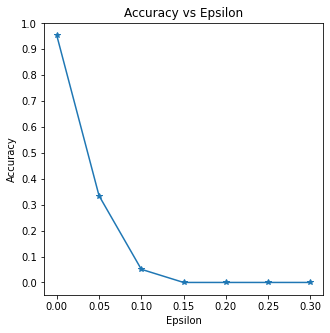

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

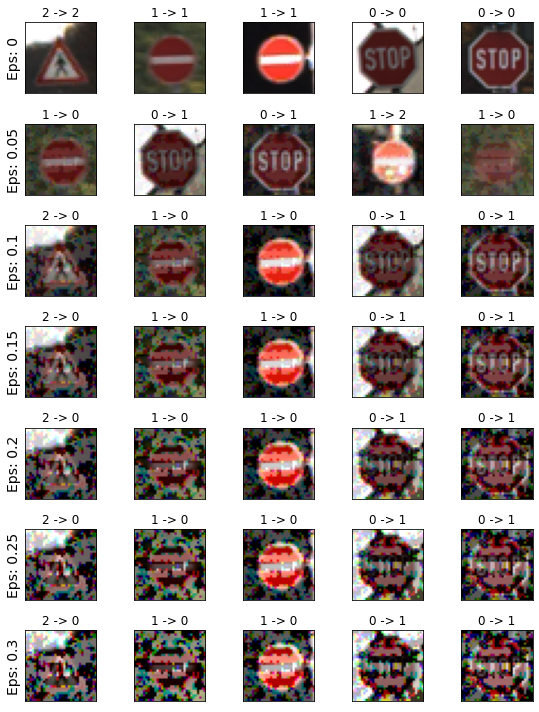

In [ ]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.reshape((32,32,3)), cmap="gray")
plt.tight_layout()
plt.show()

### 적대적 예제 데이터 생성

epsilon 값이 0.05인 경우에 대한 적대적 예제를 데이터 셋으로 만들어주겠다.

In [ ]:
for i in range(5):
    print(test_y_R[i])
    plt.imshow(data_test[i])
    plt.show()

NameError: ignored

In [ ]:
_,_, save_original_examples, saved_adversarial_examples, saved_original_output, saved_attacked_output = test(ann_R, ann_G, ann_B, test_x_R, test_y_R, test_x_G, test_y_G, test_x_B, test_y_B, 0.05, layers_dims)

Epsilon: 0.05	Test Accuracy = 274 / 690 = 0.39710144927536234


In [ ]:
saved_adversarial_examples = np.array(saved_adversarial_examples)
saved_original_output = np.array(saved_original_output)

saved_adversarial_examples = saved_adversarial_examples.reshape(-1,32,32,3)

test_R = saved_adversarial_examples[:,:,:,0]
test_G = saved_adversarial_examples[:,:,:,1]
test_B = saved_adversarial_examples[:,:,:,2]

In [ ]:
if __name__ == '__main__':
    (test_x_R, test_y_R) = test_R , saved_original_output

    test_x_R, test_y_R = pre_process_data(test_x_R, test_y_R)

    prediction_test_R = ann_R.predict_rgb_proba(test_x_R)

In [ ]:
if __name__ == '__main__':
    (test_x_G, test_y_G) = test_G , saved_original_output

    test_x_G, test_y_G = pre_process_data(test_x_G, test_y_G)

    prediction_test_G = ann_G.predict_rgb_proba(test_x_G)

In [ ]:
if __name__ == '__main__':
    (test_x_B, test_y_B) = test_B , saved_original_output

    test_x_B, test_y_B = pre_process_data(test_x_B, test_y_B)

    prediction_test_B = ann_B.predict_rgb_proba(test_x_B)

In [ ]:
print('rgb TEST Accuracy is : ', rgb_predict(prediction_test_R,prediction_test_G,prediction_test_B,test_y_R))

rgb TEST Accuracy is :  52.67175572519084


Original Prediction is :  2
Attacked Prediction is :  2
Attack failed
Original img


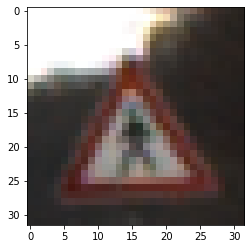

Attacked img


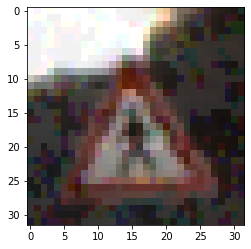

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


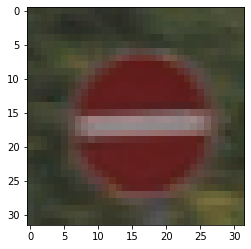

Attacked img


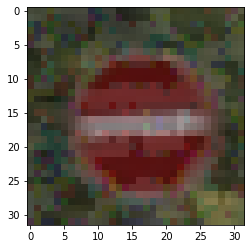

Original Prediction is :  1
Attacked Prediction is :  1
Attack failed
Original img


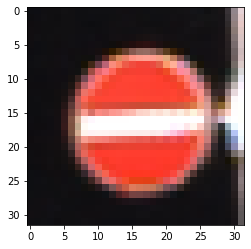

Attacked img


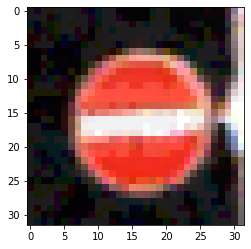

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


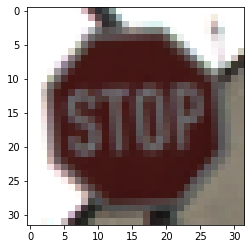

Attacked img


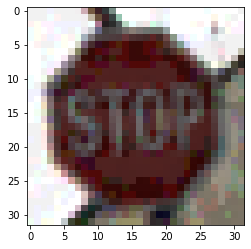

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


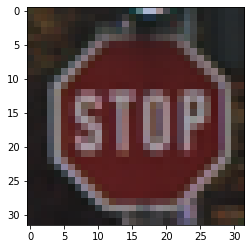

Attacked img


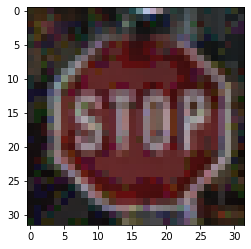

Original Prediction is :  2
Attacked Prediction is :  2
Attack failed
Original img


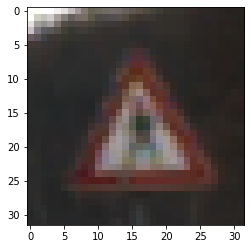

Attacked img


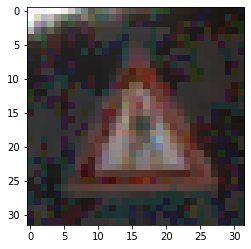

Original Prediction is :  1
Attacked Prediction is :  2
Attack success
Original img


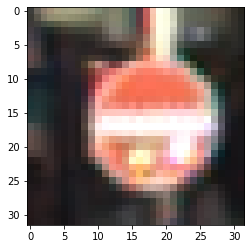

Attacked img


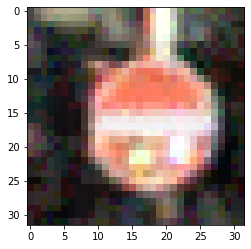

Original Prediction is :  0
Attacked Prediction is :  0
Attack failed
Original img


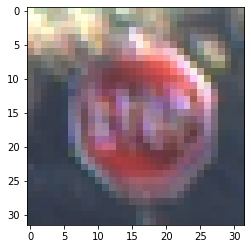

Attacked img


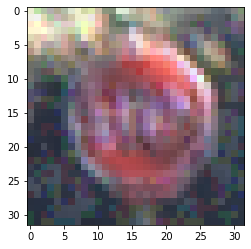

Original Prediction is :  1
Attacked Prediction is :  1
Attack failed
Original img


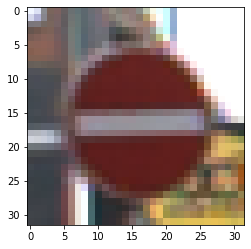

Attacked img


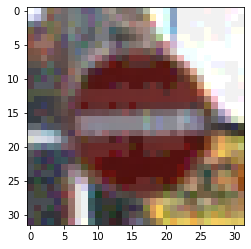

Original Prediction is :  1
Attacked Prediction is :  1
Attack failed
Original img


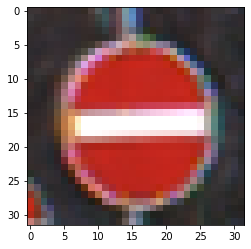

Attacked img


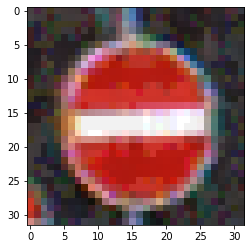

In [ ]:
at_suc_ratio = 0

for num in range(10):
    print('Original Prediction is : ',saved_original_output[num])
    print('Attacked Prediction is : ',saved_attacked_output[num])
    if saved_original_output[num] == saved_attacked_output[num]:
        print('Attack failed')
    else:
        print('Attack success')
        at_suc_ratio = at_suc_ratio + 1
    print('Original img')
    plt.imshow(save_original_examples[num].reshape((32,32,3)), cmap="gray")
    plt.show();
    print('Attacked img')
    plt.imshow(saved_adversarial_examples[num].reshape((32,32,3)), cmap="gray")
    plt.show();
    print('====================================================')

In [ ]:
print('Attacked success (%) : ',at_suc_ratio/650 * 100)

Attacked success (%) :  0.6153846153846154


Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


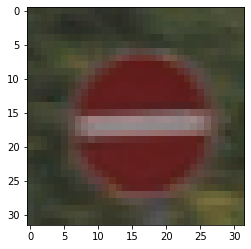

Attacked img


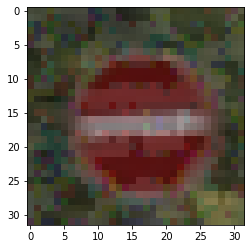

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


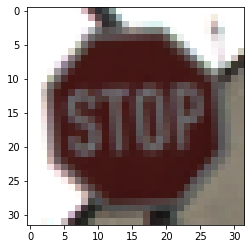

Attacked img


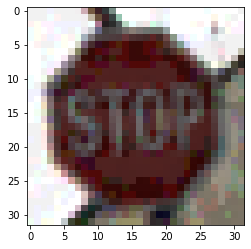

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


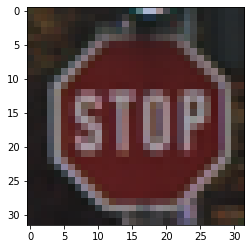

Attacked img


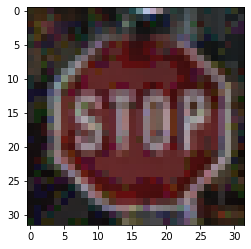

Original Prediction is :  1
Attacked Prediction is :  2
Attack success
Original img


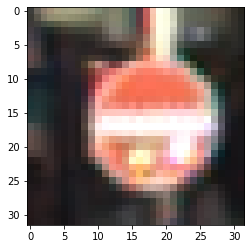

Attacked img


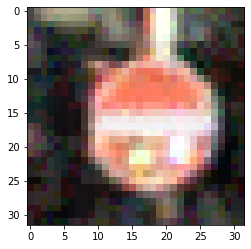

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


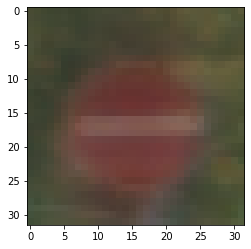

Attacked img


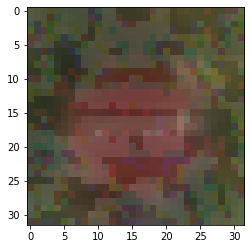

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


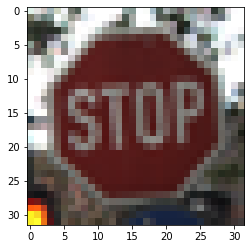

Attacked img


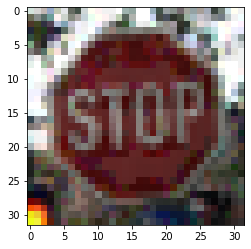

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


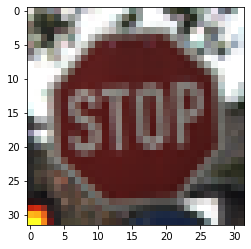

Attacked img


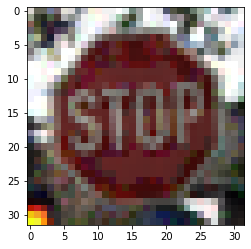

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


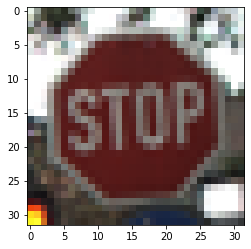

Attacked img


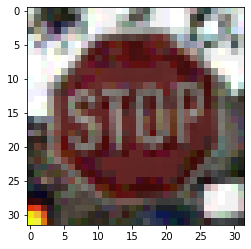

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


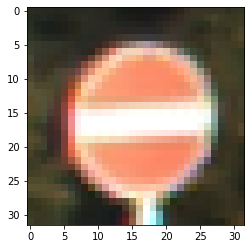

Attacked img


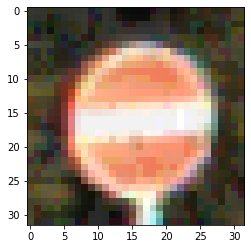

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


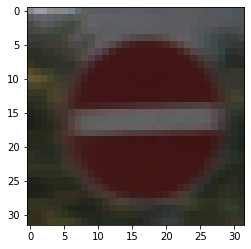

Attacked img


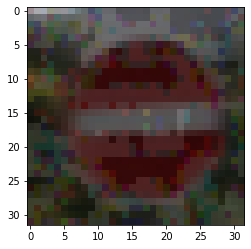

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


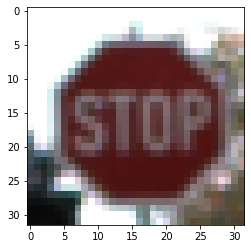

Attacked img


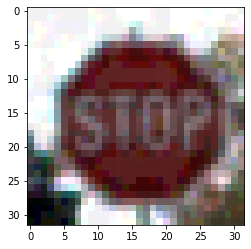

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


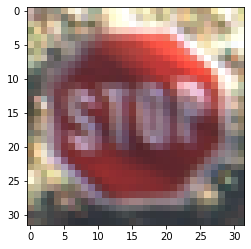

Attacked img


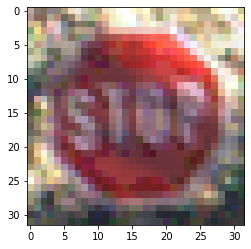

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


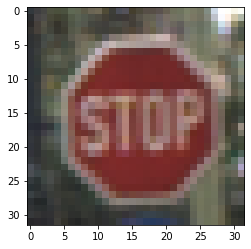

Attacked img


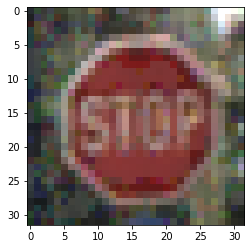

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


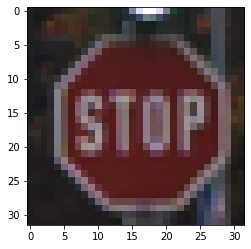

Attacked img


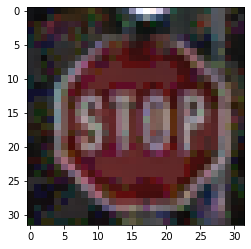

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


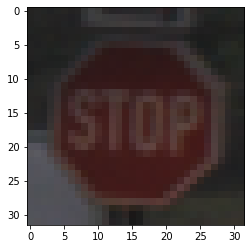

Attacked img


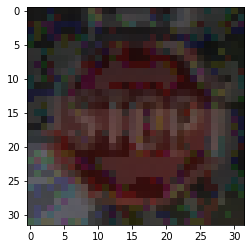

Original Prediction is :  1
Attacked Prediction is :  2
Attack success
Original img


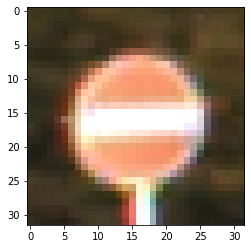

Attacked img


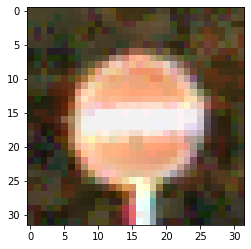

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


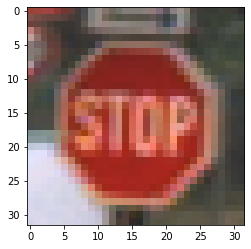

Attacked img


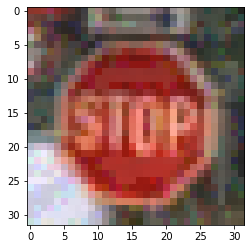

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


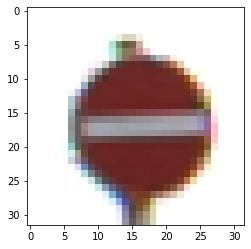

Attacked img


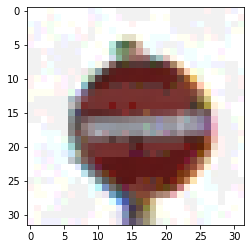

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


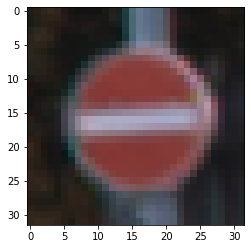

Attacked img


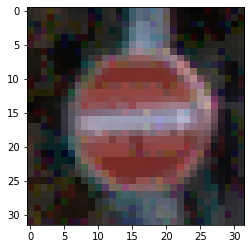

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


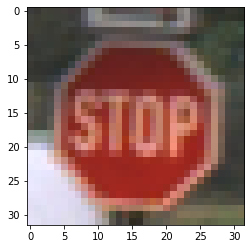

Attacked img


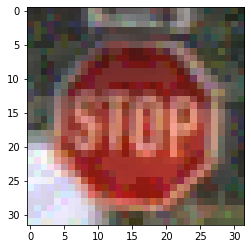

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


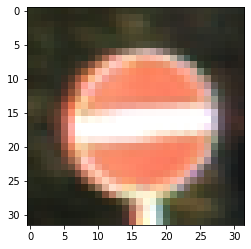

Attacked img


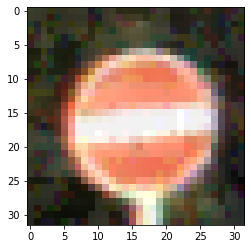

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


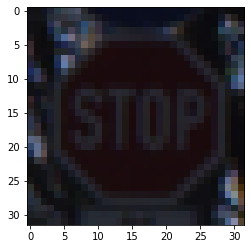

Attacked img


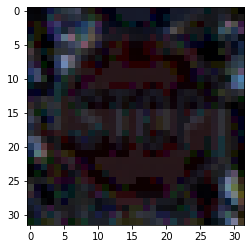

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


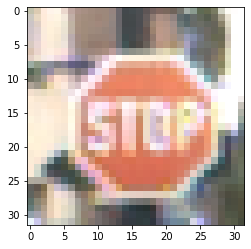

Attacked img


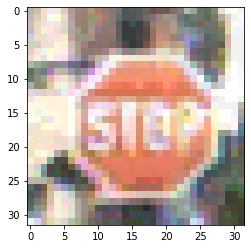

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


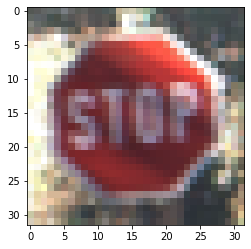

Attacked img


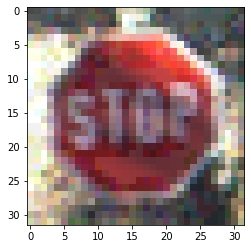

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


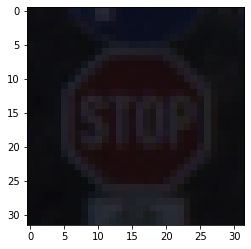

Attacked img


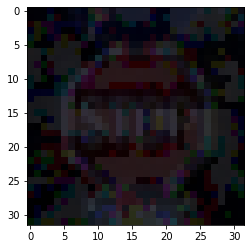

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


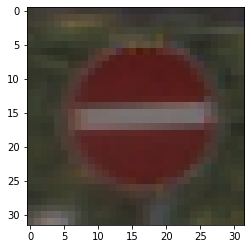

Attacked img


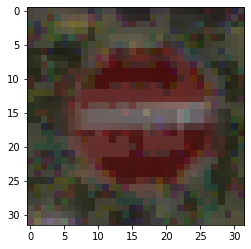

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


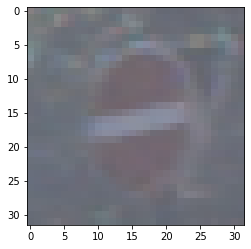

Attacked img


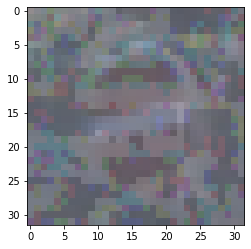

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


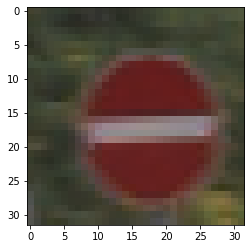

Attacked img


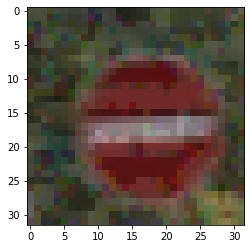

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


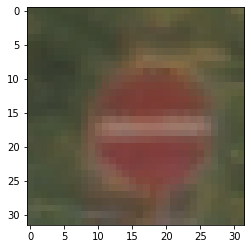

Attacked img


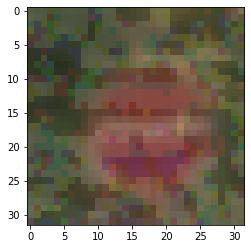

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


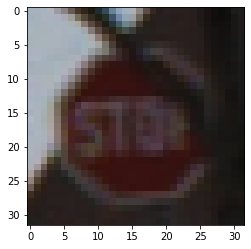

Attacked img


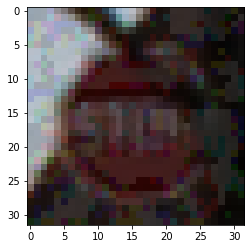

Original Prediction is :  2
Attacked Prediction is :  0
Attack success
Original img


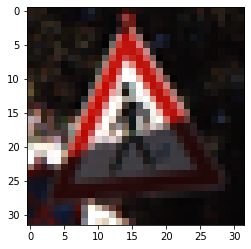

Attacked img


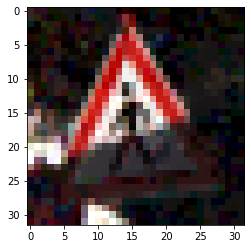

Original Prediction is :  2
Attacked Prediction is :  0
Attack success
Original img


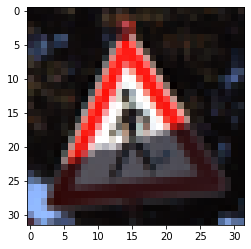

Attacked img


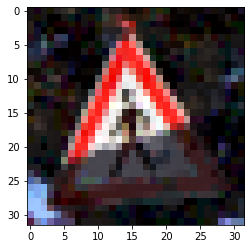

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


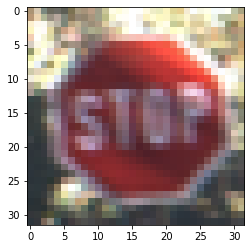

Attacked img


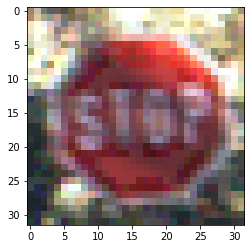

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


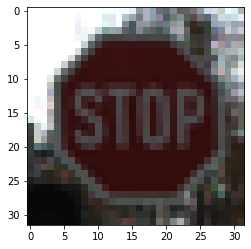

Attacked img


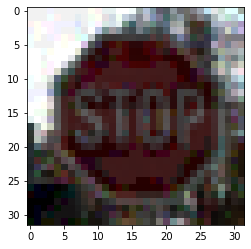

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


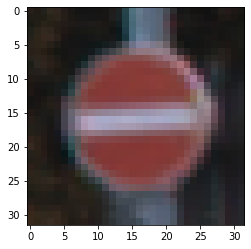

Attacked img


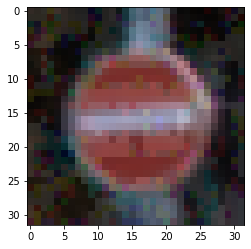

Original Prediction is :  1
Attacked Prediction is :  0
Attack success
Original img


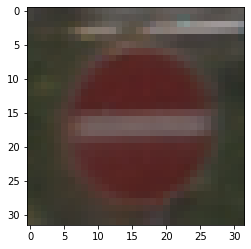

Attacked img


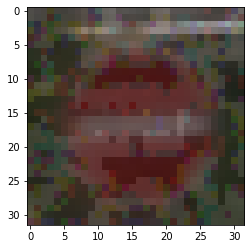

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


KeyboardInterrupt: ignored

In [ ]:
for num in range(len(saved_original_output)):
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        print('Original Prediction is : ',saved_original_output[num])
        print('Attacked Prediction is : ',saved_attacked_output[num])
        print('Attack success')
        at_suc_ratio = at_suc_ratio + 1
        print('Original img')
        plt.imshow(save_original_examples[num].reshape((32,32,3)), cmap="gray")
        plt.show();
        print('Attacked img')
        plt.imshow(saved_adversarial_examples[num].reshape((32,32,3)), cmap="gray")
        plt.show();
        print('====================================================')

공격에 성공한 이미지만 저장해주겠다

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB'

In [ ]:
cd ..

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드


In [ ]:
len(saved_original_output)

657

In [ ]:
len(saved_adversarial_examples)

657

In [ ]:
cd Attacked_test

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB/Attacked_test


In [ ]:
i = 0
#len(saved_original_output)
for num in range(len(saved_original_output)):
    number = num
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        img_name = str(number) + '.png'
        img = saved_adversarial_examples[num].reshape((32,32,3))
        img_2 = Image.fromarray((img * 255).astype(np.uint8))
        img_2.save(img_name, 'png')
        i = i + 1

In [ ]:
print(i)

427


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB/Attacked_test'

In [ ]:
cd ..

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB


In [ ]:
cd Original_test

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB/Original_test


In [ ]:
i = 0
#len(saved_original_output)
for num in range(len(saved_original_output)):
    number = num
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        img_name = str(number) + '.png'
        img = save_original_examples[num].reshape((32,32,3))
        img_2 = Image.fromarray((img * 255).astype(np.uint8))
        img_2.save(img_name, 'png')
        i = i + 1

In [ ]:
print(i)

427


In [ ]:
cd ..

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB


In [ ]:
original_test_target = []
attacked_test_target = []
#len(saved_original_output)
for num in range(len(saved_original_output)):
    number = num
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        original_test_target.append(saved_original_output[num])
        attacked_test_target.append(saved_attacked_output[num])

In [ ]:
len(attacked_test_target)

427

In [ ]:
len(original_test_target)

427

In [ ]:
ori = pd.DataFrame(original_test_target,columns = ['Original'])
ori

,Original
0,1
1,0
2,0
3,1
4,1
...,...
422,1
423,0
424,1
425,1


In [ ]:
att = pd.DataFrame(attacked_test_target, columns = ['Attacked'])
att

,Attacked
0,0
1,1
2,1
3,2
4,0
...,...
422,0
423,1
424,0
425,0


In [ ]:
data = pd.concat([ori,att],axis = 1)
data

,Original,Attacked
0,1,0
1,0,1
2,0,1
3,1,2
4,1,0
...,...,...
422,1,0
423,0,1
424,1,0
425,1,0


In [ ]:
data.to_csv('predictions_test.csv')

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB'

### Attack Data (Train)을 생성

In [ ]:
## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def train(model_R, model_G, model_B, test_x_R, test_y_R, test_x_G, test_y_G, test_x_B, test_y_B, epsilon, layers_dims):

    # 정확도 카운터
    correct = 0
    adv_examples = []
    save_original_examples = []
    save_adv_examples = []
    save_original_output = []
    save_attacked_output = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    
    for i in range(len(test_x_R)):
        data_R = test_x_R[i].reshape(1,1024)
        target_R = test_y_R[i].reshape(1,3)
        data_G = test_x_G[i].reshape(1,1024)
        target_G = test_y_G[i].reshape(1,3)
        data_B = test_x_B[i].reshape(1,1024)
        target_B = test_y_B[i].reshape(1,3)

        A_R,store_R = model_R.forward(data_R)
        A_G,store_G = model_G.forward(data_G)
        A_B,store_B = model_B.forward(data_B)

        predict_R = model_R.predict_rgb_proba(data_R)
        predict_G = model_G.predict_rgb_proba(data_G)
        predict_B = model_B.predict_rgb_proba(data_B)


        prediction = predict_R + predict_G + predict_B
        output = np.argmax(prediction, axis=0)

        init_output = int(output)
        
        if init_output != int(np.argmax(target_R,axis = 1)):
            continue


        data_grad_R = model_R.backward_ad(data_R,target_R,store_R)
        
        perturbed_data_R = fgsm_attack(data_R, epsilon, data_grad_R)

        data_grad_G = model_G.backward_ad(data_G,target_G,store_G)
        
        perturbed_data_G = fgsm_attack(data_G, epsilon, data_grad_G)

        data_grad_B = model_B.backward_ad(data_B,target_B,store_B)
        
        perturbed_data_B = fgsm_attack(data_B, epsilon, data_grad_B)


        output_R = model_R.predict_rgb_proba(perturbed_data_R)
        output_G = model_G.predict_rgb_proba(perturbed_data_G)
        output_B = model_B.predict_rgb_proba(perturbed_data_B)

        prediction_rgb = output_R + output_G + output_B
        output = np.argmax(prediction_rgb, axis=0)

        final_pred = int(output)

        if final_pred == int(np.argmax(target_R,axis = 1)):
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                perturbed_data = np.stack((perturbed_data_R, perturbed_data_G, perturbed_data_B),axis=2)
                adv_ex = perturbed_data
                adv_examples.append((init_output,final_pred,perturbed_data))
        else:
            if len(adv_examples) < 5:
                perturbed_data = np.stack((perturbed_data_R, perturbed_data_G, perturbed_data_B),axis=2)
                adv_ex = perturbed_data
                adv_examples.append((init_output,final_pred,perturbed_data))

        save_original_examples.append(np.stack((data_R, data_G, data_B),axis=2))
        save_adv_examples.append(np.stack((perturbed_data_R, perturbed_data_G, perturbed_data_B),axis=2))
        save_original_output.append(init_output)
        save_attacked_output.append(final_pred)

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x_R))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_x_R), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_original_examples, save_adv_examples, save_original_output, save_attacked_output

In [ ]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex, _, _, _, _ = train(ann_R, ann_G, ann_B, train_x_R, train_y_R, train_x_G, train_y_G, train_x_B, train_y_B, eps, layers_dims)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 2120 / 2130 = 0.9953051643192489
Epsilon: 0.05	Test Accuracy = 938 / 2130 = 0.4403755868544601
Epsilon: 0.1	Test Accuracy = 255 / 2130 = 0.11971830985915492
Epsilon: 0.15	Test Accuracy = 22 / 2130 = 0.010328638497652582
Epsilon: 0.2	Test Accuracy = 0 / 2130 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 2130 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 2130 = 0.0


In [ ]:
_,_, save_original_examples, saved_adversarial_examples, saved_original_output, saved_attacked_output = train(ann_R, ann_G, ann_B, train_x_R, train_y_R, train_x_G, train_y_G, train_x_B, train_y_B, 0.05, layers_dims)

Epsilon: 0.05	Test Accuracy = 937 / 2130 = 0.43990610328638496


Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


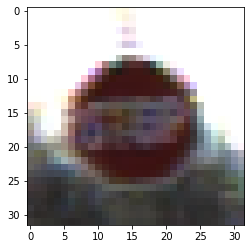

Attacked img


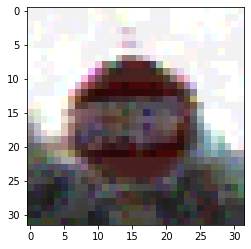

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


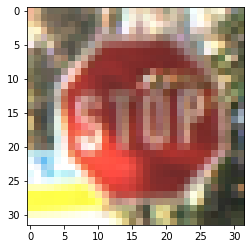

Attacked img


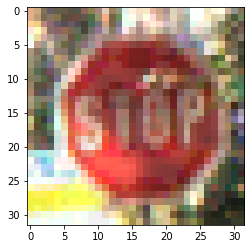

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


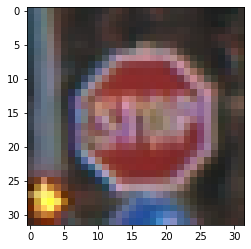

Attacked img


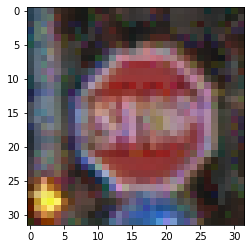

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


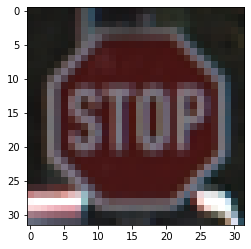

Attacked img


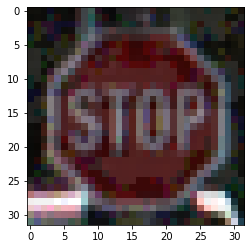

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


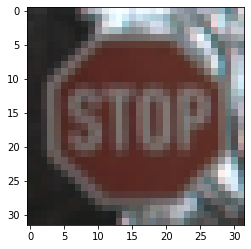

Attacked img


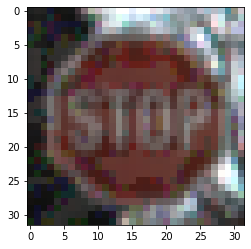

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


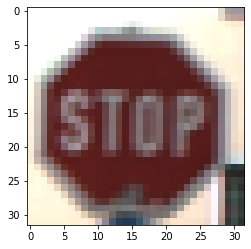

Attacked img


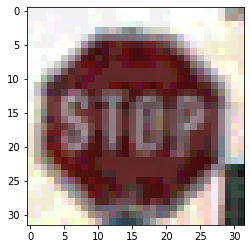

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


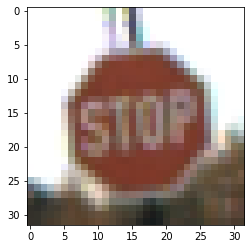

Attacked img


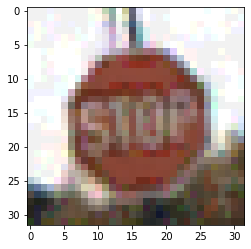

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


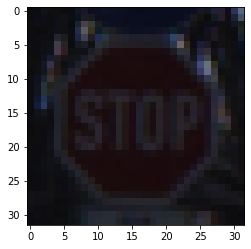

Attacked img


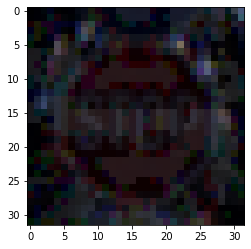

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


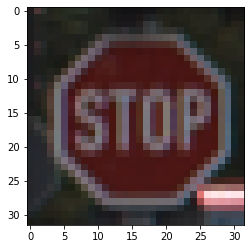

Attacked img


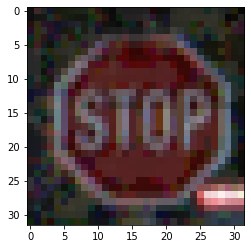

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


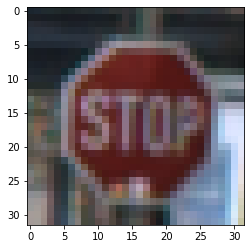

Attacked img


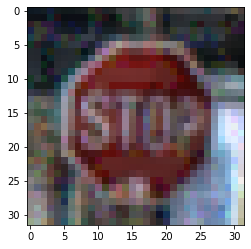

Original Prediction is :  0
Attacked Prediction is :  1
Attack success
Original img


KeyboardInterrupt: ignored

In [ ]:
for num in range(len(saved_original_output)):
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        print('Original Prediction is : ',saved_original_output[num])
        print('Attacked Prediction is : ',saved_attacked_output[num])
        print('Attack success')
        print('Original img')
        plt.imshow(save_original_examples[num].reshape((32,32,3)), cmap="gray")
        plt.show();
        print('Attacked img')
        plt.imshow(saved_adversarial_examples[num].reshape((32,32,3)), cmap="gray")
        plt.show();
        print('====================================================')

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB'

In [ ]:
cd Attacked_train

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB/Attacked_train


In [ ]:
len(saved_original_output)

2120

In [ ]:
len(saved_adversarial_examples)

2120

In [ ]:
i = 0
#len(saved_original_output)
for num in range(len(saved_original_output)):
    number = num
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        img_name = str(number) + '.png'
        img = saved_adversarial_examples[num].reshape((32,32,3))
        img_2 = Image.fromarray((img * 255).astype(np.uint8))
        img_2.save(img_name, 'png')
        i = i + 1

In [ ]:
print(i)

1183


In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB/Attacked_train'

In [ ]:
cd ..

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB


In [ ]:
cd Original_train

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB/Original_train


In [ ]:
I = 0
#len(saved_original_output)
for num in range(len(saved_original_output)):
    number = num
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        img_name = str(number) + '.png'
        img = save_original_examples[num].reshape((32,32,3))
        img_2 = Image.fromarray((img * 255).astype(np.uint8))
        img_2.save(img_name, 'png')
        I = I + 1

In [ ]:
print(I)

1183


In [ ]:
cd .. 

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB


In [ ]:
i = 0
original_test_target = []
attacked_test_target = []
#len(saved_original_output)
for num in range(len(saved_original_output)):
    number = num
    if saved_original_output[num] == saved_attacked_output[num]:
        continue
    else:
        original_test_target.append(saved_original_output[num])
        attacked_test_target.append(saved_attacked_output[num])
        i = i + 1

print(i)

1183


In [ ]:
print(len(original_test_target))
print(len(attacked_test_target))

1183
1183


In [ ]:
ori = pd.DataFrame(original_test_target,columns = ['Original'])
ori

att = pd.DataFrame(attacked_test_target, columns = ['Attacked'])
att

data = pd.concat([ori,att],axis = 1)
data

,Original,Attacked
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1178,2,1
1179,2,1
1180,2,1
1181,2,1


In [ ]:
data.to_csv('predictions_train.csv')

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/Attacked_GTSRB'